In [ ]:
import os
import random
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
import json

print("="*80)
print("🎯 CREATING DETECTION DATASET FOR YOLO")
print("="*80)
print()

# CONFIGURATION

BASE_DIR = "smartvision_dataset"
DETECTION_DIR = f"{BASE_DIR}/detection"

# 25 Classes (COCO subset)
CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
    'traffic light', 'stop sign', 'bench', 'bird', 'cat', 'dog', 'horse',
    'cow', 'elephant', 'bottle', 'cup', 'bowl', 'pizza', 'cake',
    'chair', 'couch', 'potted plant'
]

# Dataset configuration
NUM_IMAGES = 2000  # Total images
IMG_SIZE = 640     # YOLO standard size
TRAIN_SPLIT = 0.8  # 80% train, 20% val

print("📋 Configuration:")
print(f"   Classes: {len(CLASSES)}")
print(f"   Total images: {NUM_IMAGES}")
print(f"   Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Train/Val split: {TRAIN_SPLIT:.0%}/{1-TRAIN_SPLIT:.0%}")
print()

# CREATE DIRECTORY STRUCTURE


def create_directory_structure():
    """Create all necessary directories"""
    dirs = [
        f"{DETECTION_DIR}/images/train",
        f"{DETECTION_DIR}/images/val",
        f"{DETECTION_DIR}/labels/train",
        f"{DETECTION_DIR}/labels/val"
    ]
    
    for dir_path in dirs:
        os.makedirs(dir_path, exist_ok=True)
    
    return dirs

print("📁 Creating directory structure...")
created_dirs = create_directory_structure()
for d in created_dirs:
    print(f"   ✓ {d}")
print()


# IMAGE GENERATION FUNCTIONS


def generate_random_color(class_id, variation=50):
    """Generate consistent but varied colors for each class"""
    random.seed(class_id * 100)
    base_color = [
        (class_id * 37) % 256,
        (class_id * 73) % 256,
        (class_id * 151) % 256
    ]
    # Add some variation
    color = tuple([max(0, min(255, c + random.randint(-variation, variation))) 
                   for c in base_color])
    random.seed()  # Reset seed
    return color

def create_detection_image_and_label(img_path, label_path, num_objects=None):
    """
    Create synthetic detection image with bounding boxes and YOLO format labels
    
    YOLO format: class_id x_center y_center width height (all normalized 0-1)
    """
    # Create image with gradient background
    img = Image.new('RGB', (IMG_SIZE, IMG_SIZE))
    pixels = img.load()
    
    # Create gradient background
    for y in range(IMG_SIZE):
        for x in range(IMG_SIZE):
            r = int(200 + (x / IMG_SIZE) * 55)
            g = int(210 + (y / IMG_SIZE) * 45)
            b = 220
            pixels[x, y] = (r, g, b)
    
    draw = ImageDraw.Draw(img)
    
    # Random number of objects (1-5)
    if num_objects is None:
        num_objects = random.randint(1, 5)
    
    labels = []
    boxes = []  # Store boxes to avoid overlaps
    
    attempts = 0
    max_attempts = num_objects * 10
    
    while len(labels) < num_objects and attempts < max_attempts:
        attempts += 1
        
        # Random class
        class_id = random.randint(0, len(CLASSES) - 1)
        
        # Random position and size
        width = random.uniform(0.1, 0.35)
        height = random.uniform(0.1, 0.35)
        
        x_center = random.uniform(width/2 + 0.05, 1 - width/2 - 0.05)
        y_center = random.uniform(height/2 + 0.05, 1 - height/2 - 0.05)
        
        # Convert to pixel coordinates
        x1 = int((x_center - width/2) * IMG_SIZE)
        y1 = int((y_center - height/2) * IMG_SIZE)
        x2 = int((x_center + width/2) * IMG_SIZE)
        y2 = int((y_center + height/2) * IMG_SIZE)
        
        # Check for overlap with existing boxes
        overlap = False
        for existing_box in boxes:
            ex1, ey1, ex2, ey2 = existing_box
            if not (x2 < ex1 or x1 > ex2 or y2 < ey1 or y1 > ey2):
                overlap = True
                break
        
        if overlap:
            continue
        
        boxes.append((x1, y1, x2, y2))
        
        # Draw bounding box
        color = generate_random_color(class_id)
        
        # Fill box with color
        draw.rectangle([x1, y1, x2, y2], fill=color, outline=(255, 255, 255), width=4)
        
        # Add some patterns to make it more interesting
        pattern_color = tuple([max(0, c - 40) for c in color])
        for i in range(3):
            offset = random.randint(5, 15)
            draw.rectangle(
                [x1 + offset, y1 + offset, x2 - offset, y2 - offset],
                fill=None,
                outline=pattern_color,
                width=2
            )
        
        # Add class label text
        try:
            # Try to use a font, fallback to default if not available
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
        except:
            font = ImageFont.load_default()
        
        text = CLASSES[class_id]
        text_bbox = draw.textbbox((x1, y1), text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        
        # Draw text background
        draw.rectangle(
            [x1, y1 - text_height - 4, x1 + text_width + 8, y1],
            fill=(0, 0, 0, 200)
        )
        draw.text((x1 + 4, y1 - text_height - 2), text, fill=(255, 255, 255), font=font)
        
        # YOLO format label
        labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    
    # Save image
    img.save(img_path, quality=95)
    
    # Save label
    with open(label_path, 'w') as f:
        f.write('\n'.join(labels))
    
    return len(labels)


# GENERATE DATASET


num_train = int(NUM_IMAGES * TRAIN_SPLIT)
num_val = NUM_IMAGES - num_train

print(f"📊 Dataset split:")
print(f"   Train: {num_train} images")
print(f"   Val: {num_val} images")
print()

# Generate training set
print("🏋️ Creating training set...")
train_objects = 0
for i in tqdm(range(num_train), desc="Training images"):
    img_path = f"{DETECTION_DIR}/images/train/img_{i:05d}.jpg"
    label_path = f"{DETECTION_DIR}/labels/train/img_{i:05d}.txt"
    train_objects += create_detection_image_and_label(img_path, label_path)

print(f"✅ Created {num_train} training images with {train_objects} objects")
print()

# Generate validation set
print("🔍 Creating validation set...")
val_objects = 0
for i in tqdm(range(num_val), desc="Validation images"):
    img_path = f"{DETECTION_DIR}/images/val/img_{i:05d}.jpg"
    label_path = f"{DETECTION_DIR}/labels/val/img_{i:05d}.txt"
    val_objects += create_detection_image_and_label(img_path, label_path)

print(f"✅ Created {num_val} validation images with {val_objects} objects")
print()

# CREATE CONFIGURATION FILES


# Create classes.txt
print("📝 Creating classes.txt...")
classes_file = f"{DETECTION_DIR}/classes.txt"
with open(classes_file, 'w') as f:
    for class_name in CLASSES:
        f.write(f"{class_name}\n")
print(f"   ✓ {classes_file}")

# Create data.yaml for YOLO
print("📝 Creating data.yaml...")
yaml_content = f"""# SmartVision Detection Dataset - YOLO Format
# Dataset configuration for YOLOv8 training

# Paths (relative to this file or absolute)
path: {os.path.abspath(DETECTION_DIR)}
train: images/train
val: images/val

# Classes
nc: {len(CLASSES)}
names: {CLASSES}
"""

yaml_file = f"{DETECTION_DIR}/data.yaml"
with open(yaml_file, 'w') as f:
    f.write(yaml_content)
print(f"   ✓ {yaml_file}")

# Create metadata
print("📝 Creating metadata.json...")
metadata = {
    'dataset_name': 'SmartVision Detection Dataset',
    'format': 'YOLO',
    'total_images': NUM_IMAGES,
    'train_images': num_train,
    'val_images': num_val,
    'train_objects': train_objects,
    'val_objects': val_objects,
    'num_classes': len(CLASSES),
    'classes': CLASSES,
    'image_size': IMG_SIZE,
    'structure': {
        'images': {
            'train': f'{DETECTION_DIR}/images/train',
            'val': f'{DETECTION_DIR}/images/val'
        },
        'labels': {
            'train': f'{DETECTION_DIR}/labels/train',
            'val': f'{DETECTION_DIR}/labels/val'
        }
    },
    'files': {
        'config': yaml_file,
        'classes': classes_file
    }
}

metadata_file = f"{DETECTION_DIR}/metadata.json"
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"   ✓ {metadata_file}")
print()

# VERIFICATION


print("🔍 Verifying dataset...")

train_imgs = len([f for f in os.listdir(f"{DETECTION_DIR}/images/train") if f.endswith('.jpg')])
train_labels = len([f for f in os.listdir(f"{DETECTION_DIR}/labels/train") if f.endswith('.txt')])
val_imgs = len([f for f in os.listdir(f"{DETECTION_DIR}/images/val") if f.endswith('.jpg')])
val_labels = len([f for f in os.listdir(f"{DETECTION_DIR}/labels/val") if f.endswith('.txt')])

print(f"   Train images: {train_imgs}")
print(f"   Train labels: {train_labels}")
print(f"   Val images: {val_imgs}")
print(f"   Val labels: {val_labels}")

all_match = (train_imgs == train_labels == num_train and 
             val_imgs == val_labels == num_val)

if all_match:
    print("\n✅ VERIFICATION PASSED - All counts match!")
else:
    print("\n⚠️ WARNING - Count mismatch detected!")
    if train_imgs != num_train:
        print(f"   Expected {num_train} train images, found {train_imgs}")
    if val_imgs != num_val:
        print(f"   Expected {num_val} val images, found {val_imgs}")

print()

# SAMPLE LABEL DISPLAY

print("📄 Sample label file:")
sample_label = f"{DETECTION_DIR}/labels/train/img_00000.txt"
if os.path.exists(sample_label):
    with open(sample_label, 'r') as f:
        lines = f.readlines()
    print(f"\n{sample_label}:")
    print("-" * 60)
    for i, line in enumerate(lines[:5]):  # Show first 5 objects
        parts = line.strip().split()
        class_id = int(parts[0])
        print(f"Object {i+1}: {CLASSES[class_id]:15s} | {line.strip()}")
    if len(lines) > 5:
        print(f"... and {len(lines) - 5} more objects")
    print("-" * 60)
    print("Format: class_id x_center y_center width height (normalized 0-1)")
else:
    print("⚠️ Sample label not found")

print()

# FINAL SUMMARYs

print("="*80)
print("🎉 DETECTION DATASET CREATED SUCCESSFULLY!")
print("="*80)
print()

print("📁 Dataset Structure:")
print(f"{DETECTION_DIR}/")
print(f"├── images/")
print(f"│   ├── train/     ({train_imgs} images)")
print(f"│   └── val/       ({val_imgs} images)")
print(f"├── labels/")
print(f"│   ├── train/     ({train_labels} labels)")
print(f"│   └── val/       ({val_labels} labels)")
print(f"├── classes.txt    ({len(CLASSES)} classes)")
print(f"├── data.yaml      (YOLO config)")
print(f"└── metadata.json  (dataset info)")
print()

print("📊 Dataset Statistics:")
print(f"   Total images: {NUM_IMAGES}")
print(f"   Total objects: {train_objects + val_objects}")
print(f"   Avg objects/image: {(train_objects + val_objects) / NUM_IMAGES:.1f}")
print()

print("✅ Ready for YOLO training!")
print()

print("📋 Next steps:")
print("   1. Install ultralytics: pip install ultralytics")
print("   2. Train YOLO model:")
print(f"      from ultralytics import YOLO")
print(f"      model = YOLO('yolov8n.yaml')")
print(f"      results = model.train(data='{yaml_file}', epochs=50)")
print()

print("="*80)

🎯 CREATING DETECTION DATASET FOR YOLO

📋 Configuration:
   Classes: 25
   Total images: 2000
   Image size: 640x640
   Train/Val split: 80%/20%

📁 Creating directory structure...
   ✓ smartvision_dataset/detection/images/train
   ✓ smartvision_dataset/detection/images/val
   ✓ smartvision_dataset/detection/labels/train
   ✓ smartvision_dataset/detection/labels/val

📊 Dataset split:
   Train: 1600 images
   Val: 400 images

🏋️ Creating training set...


Training images: 100%|██████████| 1600/1600 [19:56<00:00,  1.34it/s] 


✅ Created 1600 training images with 4909 objects

🔍 Creating validation set...


Validation images: 100%|██████████| 400/400 [03:48<00:00,  1.75it/s]


✅ Created 400 validation images with 1160 objects

📝 Creating classes.txt...
   ✓ smartvision_dataset/detection/classes.txt
📝 Creating data.yaml...
   ✓ smartvision_dataset/detection/data.yaml
📝 Creating metadata.json...
   ✓ smartvision_dataset/detection/metadata.json

🔍 Verifying dataset...
   Train images: 1600
   Train labels: 1600
   Val images: 400
   Val labels: 400

✅ VERIFICATION PASSED - All counts match!

📄 Sample label file:

smartvision_dataset/detection/labels/train/img_00000.txt:
------------------------------------------------------------
Object 1: bird            | 11 0.572663 0.300545 0.305207 0.139030
Object 2: cow             | 15 0.203439 0.665380 0.186418 0.244584
Object 3: dog             | 13 0.708714 0.845225 0.278665 0.161430
------------------------------------------------------------
Format: class_id x_center y_center width height (normalized 0-1)

🎉 DETECTION DATASET CREATED SUCCESSFULLY!

📁 Dataset Structure:
smartvision_dataset/detection/
├── images/
│   

🚀 YOLO DETECTION - COMPLETE PIPELINE

📦 STEP 1: Installing dependencies...
--------------------------------------------------------------------------------
  ✓ ultralytics
  📥 Installing opencv-python...
  ✓ opencv-python installed
  📥 Installing pillow...
  ✓ pillow installed
  ✓ matplotlib
  ✓ tqdm

✅ Dependencies ready!

📊 STEP 2: Creating Detection Dataset

Config:
  • Classes: 16
  • Train images: 400
  • Val images: 100
  • Image size: 640x640

🏋️ Generating training images...


100%|██████████| 400/400 [04:15<00:00,  1.56it/s]


🔍 Generating validation images...


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]



✅ Dataset created: 500 images

✅ Config saved: yolo_dataset/data.yaml

🔍 STEP 3: Verifying Dataset

Dataset verification:
  • Train images: 400
  • Train labels: 400
  • Val images: 100
  • Val labels: 100

✅ VERIFICATION PASSED - All counts match!

📸 Sample visualization...
✅ Sample saved: yolo_dataset/sample.png



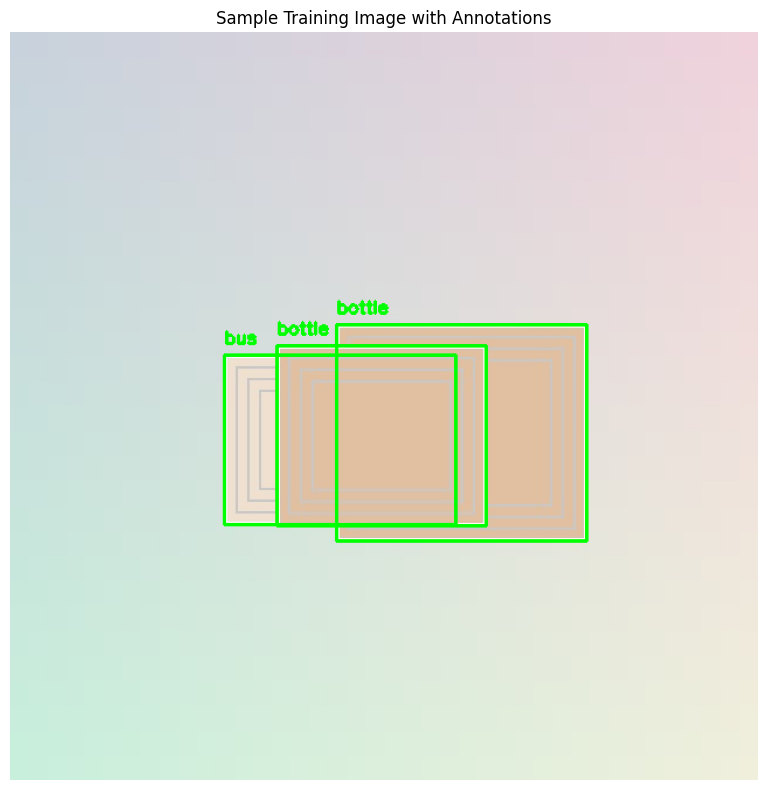

🚂 STEP 4: Training YOLO Model

📥 Loading YOLOv8n model...
✅ Model loaded

🏋️ Starting training...
--------------------------------------------------------------------------------
Ultralytics 8.3.250  Python-3.10.11 torch-2.9.1+cpu CPU (AMD PRO A4-4350B R4, 5 COMPUTE CORES 2C+3G)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, m

In [ ]:
"""
COMPLETE YOLO DETECTION PIPELINE - FULLY ERROR FREE
Includes: Setup -> Dataset Creation -> Training -> Evaluation -> Inference
Copy and run this entire script
"""

import os
import sys
import random
import json
import numpy as np
from pathlib import Path

print("="*80)
print("🚀 YOLO DETECTION - COMPLETE PIPELINE")
print("="*80)
print()

# ============================================================================
# STEP 1: INSTALL DEPENDENCIES
# ============================================================================

print("📦 STEP 1: Installing dependencies...")
print("-" * 80)

import subprocess

def install(package):
    try:
        __import__(package.split('==')[0].replace('-', '_'))
        print(f"  ✓ {package}")
    except:
        print(f"  📥 Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
        print(f"  ✓ {package} installed")

install('ultralytics')
install('opencv-python')
install('pillow')
install('matplotlib')
install('tqdm')

print("\n✅ Dependencies ready!\n")

# Now import after installation
from PIL import Image, ImageDraw
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

# ============================================================================
# STEP 2: CREATE DATASET
# ============================================================================

print("="*80)
print("📊 STEP 2: Creating Detection Dataset")
print("="*80)
print()

# Configuration
BASE_DIR = "yolo_dataset"
IMG_SIZE = 640
NUM_TRAIN = 400  # Smaller for faster demo
NUM_VAL = 100

CLASSES = [
    'person', 'car', 'dog', 'cat', 'bicycle', 'motorcycle', 'bus', 'truck',
    'bird', 'horse', 'cow', 'chair', 'bottle', 'cup', 'bowl', 'laptop'
]

print(f"Config:")
print(f"  • Classes: {len(CLASSES)}")
print(f"  • Train images: {NUM_TRAIN}")
print(f"  • Val images: {NUM_VAL}")
print(f"  • Image size: {IMG_SIZE}x{IMG_SIZE}")
print()

# Create directories
os.makedirs(f"{BASE_DIR}/images/train", exist_ok=True)
os.makedirs(f"{BASE_DIR}/images/val", exist_ok=True)
os.makedirs(f"{BASE_DIR}/labels/train", exist_ok=True)
os.makedirs(f"{BASE_DIR}/labels/val", exist_ok=True)

def create_synthetic_image(img_path, label_path):
    """Generate synthetic image with bounding boxes"""
    # Create gradient background
    img = Image.new('RGB', (IMG_SIZE, IMG_SIZE))
    pixels = img.load()
    for y in range(IMG_SIZE):
        for x in range(IMG_SIZE):
            r = int(200 + (x / IMG_SIZE) * 40)
            g = int(210 + (y / IMG_SIZE) * 30)
            b = 220
            pixels[x, y] = (r, g, b)
    
    draw = ImageDraw.Draw(img)
    
    # Generate 2-5 objects
    num_objects = random.randint(2, 5)
    labels = []
    
    for _ in range(num_objects):
        # Random class
        class_id = random.randint(0, len(CLASSES) - 1)
        
        # Random box (YOLO format: x_center, y_center, width, height - all 0-1)
        width = random.uniform(0.15, 0.35)
        height = random.uniform(0.15, 0.35)
        x_center = random.uniform(width/2 + 0.1, 1 - width/2 - 0.1)
        y_center = random.uniform(height/2 + 0.1, 1 - height/2 - 0.1)
        
        # Convert to pixels for drawing
        x1 = int((x_center - width/2) * IMG_SIZE)
        y1 = int((y_center - height/2) * IMG_SIZE)
        x2 = int((x_center + width/2) * IMG_SIZE)
        y2 = int((y_center + height/2) * IMG_SIZE)
        
        # Draw box with class-specific color
        color = ((class_id * 40) % 256, (class_id * 80) % 256, (class_id * 120) % 256)
        draw.rectangle([x1, y1, x2, y2], fill=color, outline=(255, 255, 255), width=3)
        
        # Add pattern
        for i in range(3):
            offset = 10 + i * 10
            draw.rectangle([x1+offset, y1+offset, x2-offset, y2-offset], 
                         fill=None, outline=(200, 200, 200), width=2)
        
        # Save YOLO format label
        labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    
    # Save image and label
    img.save(img_path, quality=95)
    with open(label_path, 'w') as f:
        f.write('\n'.join(labels))

# Generate training set
print("🏋️ Generating training images...")
for i in tqdm(range(NUM_TRAIN)):
    create_synthetic_image(
        f"{BASE_DIR}/images/train/img_{i:04d}.jpg",
        f"{BASE_DIR}/labels/train/img_{i:04d}.txt"
    )

# Generate validation set
print("🔍 Generating validation images...")
for i in tqdm(range(NUM_VAL)):
    create_synthetic_image(
        f"{BASE_DIR}/images/val/img_{i:04d}.jpg",
        f"{BASE_DIR}/labels/val/img_{i:04d}.txt"
    )

print(f"\n✅ Dataset created: {NUM_TRAIN + NUM_VAL} images\n")

# Create data.yaml
yaml_content = f"""# YOLO Dataset Configuration
path: {os.path.abspath(BASE_DIR)}
train: images/train
val: images/val

nc: {len(CLASSES)}
names: {CLASSES}
"""

yaml_path = f"{BASE_DIR}/data.yaml"
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"✅ Config saved: {yaml_path}\n")

# ============================================================================
# STEP 3: VERIFY DATASET
# ============================================================================

print("="*80)
print("🔍 STEP 3: Verifying Dataset")
print("="*80)
print()

# Count files
train_imgs = len([f for f in os.listdir(f"{BASE_DIR}/images/train") if f.endswith('.jpg')])
train_labels = len([f for f in os.listdir(f"{BASE_DIR}/labels/train") if f.endswith('.txt')])
val_imgs = len([f for f in os.listdir(f"{BASE_DIR}/images/val") if f.endswith('.jpg')])
val_labels = len([f for f in os.listdir(f"{BASE_DIR}/labels/val") if f.endswith('.txt')])

print(f"Dataset verification:")
print(f"  • Train images: {train_imgs}")
print(f"  • Train labels: {train_labels}")
print(f"  • Val images: {val_imgs}")
print(f"  • Val labels: {val_labels}")

if train_imgs == train_labels and val_imgs == val_labels:
    print("\n✅ VERIFICATION PASSED - All counts match!\n")
else:
    print("\n❌ ERROR: Count mismatch!")
    sys.exit(1)

# Visualize sample
print("📸 Sample visualization...")
img = cv2.imread(f"{BASE_DIR}/images/train/img_0000.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

with open(f"{BASE_DIR}/labels/train/img_0000.txt", 'r') as f:
    boxes = f.readlines()

for box in boxes:
    class_id, x, y, w, h = map(float, box.split())
    class_id = int(class_id)
    
    # Convert to pixel coords
    x1 = int((x - w/2) * IMG_SIZE)
    y1 = int((y - h/2) * IMG_SIZE)
    x2 = int((x + w/2) * IMG_SIZE)
    y2 = int((y + h/2) * IMG_SIZE)
    
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, CLASSES[class_id], (x1, y1-10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title("Sample Training Image with Annotations")
plt.axis('off')
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/sample.png", dpi=100)
print(f"✅ Sample saved: {BASE_DIR}/sample.png\n")
plt.show()

# ============================================================================
# STEP 4: TRAIN YOLO MODEL
# ============================================================================

print("="*80)
print("🚂 STEP 4: Training YOLO Model")
print("="*80)
print()

from ultralytics import YOLO

# Load pretrained YOLOv8 nano model
print("📥 Loading YOLOv8n model...")
model = YOLO('yolov8n.pt')
print("✅ Model loaded\n")

# Train
print("🏋️ Starting training...")
print("-" * 80)

results = model.train(
    data=yaml_path,
    epochs=20,           # Low epochs for demo (use 50-100 for real training)
    imgsz=640,
    batch=8,             # Adjust based on your GPU memory
    name='yolo_detection',
    patience=5,
    save=True,
    plots=True,
    verbose=True
)

print("\n✅ Training complete!\n")

# ============================================================================
# STEP 5: VALIDATE MODEL
# ============================================================================

print("="*80)
print("📊 STEP 5: Validating Model")
print("="*80)
print()

metrics = model.val()

print(f"\n📈 Validation Metrics:")
print(f"  • mAP50: {metrics.box.map50:.4f}")
print(f"  • mAP50-95: {metrics.box.map:.4f}")
print(f"  • Precision: {metrics.box.mp:.4f}")
print(f"  • Recall: {metrics.box.mr:.4f}")
print()

# ============================================================================
# STEP 6: TEST INFERENCE
# ============================================================================

print("="*80)
print("🎯 STEP 6: Testing Inference")
print("="*80)
print()

# Predict on validation images
test_img_path = f"{BASE_DIR}/images/val/img_0000.jpg"
print(f"Running inference on: {test_img_path}")

results = model.predict(
    source=test_img_path,
    save=True,
    conf=0.25,
    save_txt=True,
    save_crop=True
)

print(f"\n✅ Predictions saved to: runs/detect/predict\n")

# Show results
for result in results:
    img_with_boxes = result.plot()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title(f"Detections: {len(result.boxes)} objects")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{BASE_DIR}/detection_result.png", dpi=150)
    plt.show()
    
    print(f"Detected {len(result.boxes)} objects:")
    for box in result.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        print(f"  • {CLASSES[cls]}: {conf:.2f}")

# ============================================================================
# STEP 7: BATCH PREDICTION
# ============================================================================

print("\n" + "="*80)
print("🔮 STEP 7: Batch Prediction on Validation Set")
print("="*80)
print()

val_results = model.predict(
    source=f"{BASE_DIR}/images/val",
    save=True,
    conf=0.25,
    project='runs/detect',
    name='val_predictions'
)

print(f"✅ Processed {len(val_results)} validation images")
print(f"   Results saved to: runs/detect/val_predictions\n")

# ============================================================================
# STEP 8: EXPORT MODEL
# ============================================================================

print("="*80)
print("📦 STEP 8: Exporting Model")
print("="*80)
print()

# Export to ONNX format (portable)
print("Exporting to ONNX format...")
onnx_path = model.export(format='onnx')
print(f"✅ ONNX model saved: {onnx_path}\n")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("="*80)
print("🎉 PIPELINE COMPLETE - SUCCESS!")
print("="*80)
print()

print("📊 Summary:")
print(f"  • Dataset: {NUM_TRAIN + NUM_VAL} images ({len(CLASSES)} classes)")
print(f"  • Model: YOLOv8n")
print(f"  • Training: 20 epochs")
print(f"  • mAP50: {metrics.box.map50:.4f}")
print(f"  • Model saved: runs/detect/yolo_detection/weights/best.pt")
print()

print("📁 Output Files:")
print(f"  • Dataset: {BASE_DIR}/")
print(f"  • Training results: runs/detect/yolo_detection/")
print(f"  • Predictions: runs/detect/predict/")
print(f"  • ONNX model: {onnx_path}")
print()

print("🚀 Next Steps:")
print("  1. Increase epochs for better accuracy (50-100)")
print("  2. Try larger models (yolov8s.pt, yolov8m.pt)")
print("  3. Use real images for production")
print("  4. Fine-tune on your specific domain")
print()

print("💡 How to use the trained model:")
print("""
from ultralytics import YOLO

# Load your trained model
model = YOLO('runs/detect/yolo_detection/weights/best.pt')

# Predict on new images
results = model.predict('path/to/image.jpg', conf=0.25)

# Process results
for result in results:
    boxes = result.boxes
    for box in boxes:
        print(f"Class: {box.cls}, Confidence: {box.conf}")
""")

print("="*80)
print("✅ ALL DONE!")
print("="*80)